In [1]:
import pandas as pd

In [8]:
# from Baseball Savant, get weighted pop time using TY and LY data
# min pa = 50
def read_pop_time(year):
    df = pd.read_csv(f'2B Pop Time {year - 1}-{year}.csv', index_col=False).drop('Unnamed: 6', axis=1).dropna()
                
    # for TY data, double its weight
    df['weight'] = 0
    df.loc[df['year'] == year, 'weight'] = 2
    df.loc[df['year'] != year, 'weight'] = 1
    df['weighted_pop'] = df['weight'] * df['pop_2b_sba']
        
    # calculate the weighted pop time
    df_grouped = df.groupby(['player_id']).sum()
    df_grouped['pop_2b_sba'] = df_grouped['weighted_pop'] / df_grouped['weight']
    df_grouped = df_grouped[df_grouped['year'] >= year]
    
    # join with player ids
    player_map = pd.read_csv('../../PLAYERIDMAP 2022.csv')[['MLBID', 'PLAYERNAME']].set_index('MLBID')
    merge = df_grouped[['pop_2b_sba']].merge(player_map, how='left', left_index=True, right_index=True)[['PLAYERNAME', 'pop_2b_sba']]
    
    mean = merge['pop_2b_sba'].mean()
    std = merge['pop_2b_sba'].std()
    
    merge['Z'] = -1 * ((merge['pop_2b_sba'] - mean) / std)
    
    return merge

pt_data = read_pop_time(2022)
pt_data.head()

,PLAYERNAME,pop_2b_sba,Z
425877,Yadier Molina,2.000000,-0.367457
435559,Kurt Suzuki,2.040000,-1.115733
455117,Martin Maldonado,1.933333,0.879669
455139,Robinson Chirinos,2.020000,-0.741595
488771,Jason Castro,1.970000,0.193750


0.7660918489406424
-2.4252151845824432
2.937427758002053


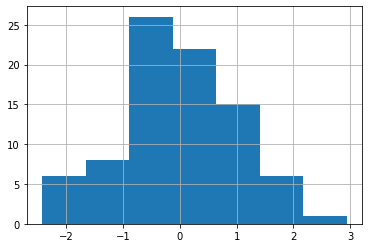

In [74]:
print((pt_data['Z'].max() - pt_data['Z'].min()) / 7)
print(pt_data['Z'].min())
print(pt_data['Z'].max())
hist = pt_data['Z'].hist(bins=7)

In [83]:
# CONVERSIONS:
# 6-12
pop_time_conversion = {
    7: -1.5,
    8: -1.0,
    9: -0.5,
    10: 0.0,
    11: 1.0,
    12: 2.0,
}

In [84]:
def get_arm(pt):
    current_arm = 6
    while current_arm < 12:
        floor = pop_time_conversion[current_arm + 1]
        if pt > floor:
            current_arm += 1
        else:
            break
    return current_arm

In [85]:
def assign_arm(year):
    arm_data = read_pop_time(2022)
    arm_data['Arm Strength'] = arm_data.apply(lambda x: get_arm(x['Z']), axis=1)
    return arm_data[['PLAYERNAME', 'Arm Strength']].dropna()

arm_df = assign_arm(2022)
arm_df.head()

,PLAYERNAME,Arm Strength
425877,Yadier Molina,9
435559,Kurt Suzuki,7
455117,Martin Maldonado,10
455139,Robinson Chirinos,8
488771,Jason Castro,10


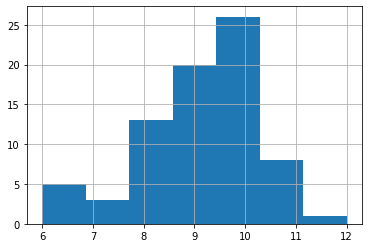

In [86]:
hist2 = arm_df['Arm Strength'].hist(bins=7)

In [87]:
arm_df.to_csv('2022_Catcher_Arm.csv')